This notebook combines the setup and image processing scripts for Omnipose, following the recommended installation procedures for Jupyter environments.

This notebook sets up the required dependencies for Omnipose using a conda virtual environment.

In [ ]:
# Create a new conda virtual environment named 'omnipose_env'
#!conda create --name omnipose_env python=3.9.13

# Activate the virtual environment
!conda activate omnipose_env

# Install the required dependencies
#%conda install -c conda-forge pytest pathlib scikit-image

# Note: 'omnipose' might need to be installed through pip or other means if it's not available in conda channels
#!pip install omnipose


The following section contains the Omnipose image processing code.

In [ ]:
# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')


Now that I have everything set up I need to load my images, which can be done in a variety of ways but here we will save them as variable "files" by importing a path and then matching file names with extensions and keywords



Original image shape: (512, 512)
data type: uint16
data range: min 12019, max 39445

Original image shape: (512, 512)
data type: uint16
data range: min 12612, max 28497

Original image shape: (512, 512)
data type: uint16
data range: min 11935, max 28729

Original image shape: (512, 512)
data type: uint16
data range: min 12121, max 28934

Original image shape: (512, 512)
data type: uint16
data range: min 12695, max 28229

Original image shape: (512, 512)
data type: uint16
data range: min 12996, max 29899

Original image shape: (512, 512)
data type: uint16
data range: min 12559, max 32924

Original image shape: (512, 512)
data type: uint16
data range: min 12365, max 31544

Original image shape: (512, 512)
data type: uint16
data range: min 11975, max 28697

Original image shape: (512, 512)
data type: uint16
data range: min 11266, max 27875


number of images: 10


new shape:  (512, 512)
new shape:  (512, 512)
new shape:  (512, 512)
new shape:  (512, 512)
new shape:  (512, 512)
new shape: 

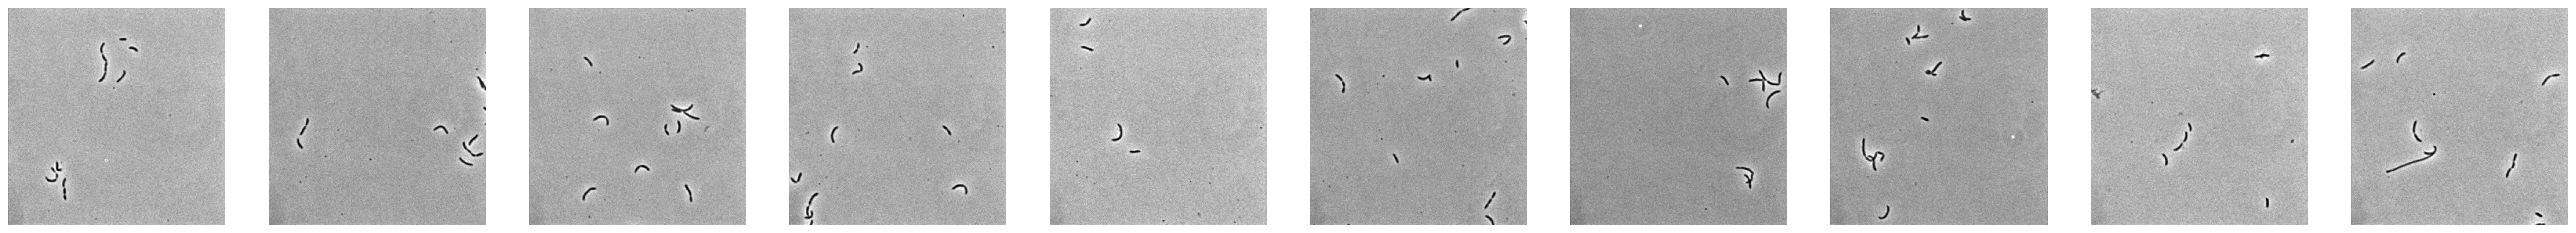

In [11]:
from pathlib import Path

basedir = r'C:\Users\MicrobeJ\Downloads\omnipose_trial'
files = [str(p) for p in Path(basedir).glob("C1-MAX-*")]

from cellpose_omni import io, transforms
from omnipose.utils import normalize99
imgs = [io.imread(f) for f in files]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range: min {}, max {}\n'.format(i.min(),i.max()))
nimg = len(imgs)
print('\nnumber of images:',nimg)

fig = plt.figure(figsize=[40]*2,frameon=False) # initialize figure
print('\n')
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])
    # imgs[k] = np.pad(imgs[k],10,'edge')
    print('new shape: ', imgs[k].shape)
    plt.subplot(1,len(files),k+1)
    plt.imshow(imgs[k],cmap='gray')
    plt.axis('off')

## Decide Which Model to use
Here we will list the models and choose which model to use. I am assuming we will almost always use the bact_phase_omni or bact_phase_cp models


In [14]:
from skimage.io import imread, imsave
import numpy as np
from pathlib import Path


from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES

MODEL_NAMES

model_name = 'bact_phase_omni'
model = models.CellposeModel(gpu=False, model_type=model_name)
use_GPU = False

import time
chans = [0,0] #this means segment based on first channel, no second channel 

n = [-1] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised 
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
niter = None # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
resample = True #whether or not to run dynamics on rescaled grid or original grid 
cluster = True # use DBSCAN clustering
augment = False # average the outputs from flipped (augmented) images; slower, usually not needed 
tile = False # break up image into smaller parts then stitch together
affinity_seg = 0 #new feature, stay tuned...

tic = time.time() 
masks, flows, styles = model.eval([imgs[i] for i in n],
                                  channels=chans,
                                  rescale=rescale,
                                  mask_threshold=mask_threshold,
                                  transparency=transparency,
                                  flow_threshold=flow_threshold,
                                  niter=niter,
                                  omni=omni,
                                  cluster=cluster, 
                                  resample=resample,
                                  verbose=verbose, 
                                  affinity_seg=affinity_seg,
                                  tile=tile,
                                  augment=augment)

net_time = time.time() - tic
print('total segmentation time: {}s'.format(net_time))

# After generating the masks, loop through the original images and apply the masks
for idx, mask in enumerate(masks):
    # Read the original image corresponding to the mask
    original_image = imread(files[idx])
    
    # Check if the original image and mask dimensions match
    if original_image.shape[:2] != mask.shape:
        print(f"Dimension mismatch for {files[idx]}")
        continue

    # If the original image is multi-channel, duplicate the mask for each channel
    if len(original_image.shape) == 3:
        mask_multi_channel = np.repeat(mask[:, :, np.newaxis], original_image.shape[2], axis=2)
    else:
        mask_multi_channel = mask

    # Apply the mask to the original image
    masked_image = original_image * (mask_multi_channel > 0)

    # Save the masked image
    filename = Path(files[idx]).name  # Extract the original filename
    base_name = Path(filename).stem  # Get the name without extension
    imsave(f"{basedir}/{base_name}_masked.tif", masked_image.astype(np.uint16))



for idx, mask in enumerate(masks):
    filename = Path(files[idx]).name  # Extract the original filename
    base_name = Path(filename).stem  # Get the name without extension
    outlines = utils.outlines_list(mask)
    io.outlines_to_text(f"{basedir}/{base_name}_outlines.txt", outlines) # saving outlines compatible with ImageJ's ROI manager 
    imsave(f"{basedir}/{base_name}_mask.tif", mask.astype(np.uint16)) #saving binary masks of the images


    




2023-08-28 14:50:51,863 [INFO] >>bact_phase_omni<< model set to be used
2023-08-28 14:50:51,865 [INFO] >>>> using CPU
2023-08-28 14:51:18,225 [INFO] 100%|##########| 10/10 [00:26<00:00,  2.62s/it]
total segmentation time: 26.171301126480103s


C:\Users\MicrobeJ\AppData\Local\Temp\ipykernel_6284\3320847390.py:77: UserWarning: C:\Users\MicrobeJ\Downloads\omnipose_trial/C1-MAX-0001_masked.tif is a low contrast image
  imsave(f"{basedir}/{base_name}_masked.tif", masked_image.astype(np.uint16))
C:\Users\MicrobeJ\AppData\Local\Temp\ipykernel_6284\3320847390.py:77: UserWarning: C:\Users\MicrobeJ\Downloads\omnipose_trial/C1-MAX-0002_masked.tif is a low contrast image
  imsave(f"{basedir}/{base_name}_masked.tif", masked_image.astype(np.uint16))
C:\Users\MicrobeJ\AppData\Local\Temp\ipykernel_6284\3320847390.py:77: UserWarning: C:\Users\MicrobeJ\Downloads\omnipose_trial/C1-MAX-0003_masked.tif is a low contrast image
  imsave(f"{basedir}/{base_name}_masked.tif", masked_image.astype(np.uint16))
C:\Users\MicrobeJ\AppData\Local\Temp\ipykernel_6284\3320847390.py:77: UserWarning: C:\Users\MicrobeJ\Downloads\omnipose_trial/C1-MAX-0004_masked.tif is a low contrast image
  imsave(f"{basedir}/{base_name}_masked.tif", masked_image.astype(np.uint1

In [ ]:
from cellpose_omni import plot
import omnipose

for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    # set up the output figure to better match the resolution of the images 
    f = 10
    szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    fig = plt.figure(figsize=(szY,szX*4))
    fig.patch.set_facecolor([0]*4)
    
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), 
                           maski, flowi, bdi, channels=chans, omni=True)

    plt.tight_layout()
    plt.show()


base = os.path.splitext(image_name)[0]
outlines = utils.outlines_list(masks)
io.outlines_to_text(base, outlines)
io.save_to_png(images, masks, flows, image_names)   

In [ ]:
from cellpose_omni import io, plot

# image_name is file name of image
# masks is numpy array of masks for image
base = os.path.splitext(image_name)[0]
outlines = utils.outlines_list(masks)
io.outlines_to_text(base, outlines)